### A Mean Reversion Strategy with 2.11 Sharpe
[Link](https://www.quantitativo.com/p/a-mean-reversion-strategy-with-211)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross
from backtesting.test import SMA
import matplotlib.pyplot as plt
import talib as ta

from createPerformanceChart import create_performance_chart

c:\Coding\Algotrading\backtesting.py\.venv\Lib\site-packages\backtesting\_plotting.py:53: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
# Define Performance Chart
def create_performance_chart(result, benchmark_result=None):
    # Get the equity curve and trades from the backtest result
    equity = result._equity_curve
    trades = result._trades
    
    # Create figure with two subplots (returns and drawdowns)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})
    
    # 1. Plot Returns (top panel) on log scale
    strategy_returns = equity['Equity'].values
    ax1.semilogy(equity.index, strategy_returns, 'blue', label='Strategy')
    
    # If benchmark is provided, plot it too
    if benchmark_result is not None:
        benchmark_equity = benchmark_result._equity_curve
        benchmark_returns = benchmark_equity['Equity'].values
        ax1.semilogy(benchmark_equity.index, benchmark_returns, 'orange', label='Buy&Hold')
    
    ax1.set_ylabel('Total Return (log scale)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Plot Drawdowns (bottom panel)
    drawdown = equity['DrawdownPct'].values
    ax2.plot(equity.index, -drawdown, 'blue')  # Negative because backtesting.py has positive drawdown values
    
    # If benchmark is provided, plot its drawdown too
    if benchmark_result is not None:
        benchmark_drawdown = benchmark_equity['DrawdownPct'].values
        ax2.plot(benchmark_equity.index, -benchmark_drawdown, 'orange')
    
    ax2.set_ylabel('Drawdown')
    ax2.set_xlabel('Year')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [4]:
def ibs(close, high, low):
    return (close - low) / (high  - low)

In [67]:
def lowerBand(high, low):
    rollingMeanHL = ta.SMA((high - low), 25)
    rollingHigh10 = ta.MAX(high, 10)
    return rollingHigh10 - 2.5 * rollingMeanHL

### First experiment with QQQ

In [64]:
# Define the strategy
class IBSBandStrategy(Strategy):
    # Parameters
    rolling_window = 25
    lower_band_window = 10
    ibs_threshold = 0.3
    multiplier = 2.5
    
    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close

        #self.rolling_mean = self.I(SMA, (close - low), self.rolling_window, plot=True, overlay=True)
        self.ibs = self.I(ibs, close, high, low, plot=True, overlay=False)
        self.lower_band = self.I(lowerBand, high, low, plot=True, overlay=True)
            
    def next(self):
        # Go long if SPY closes under the lower band and IBS is lower than 0.3
        if self.data.Close[-1] < self.lower_band[-1] and self.ibs[-1] < self.ibs_threshold and not self.position:
            self.buy()
        
        # Close the trade if SPY close is higher than yesterday's high
        if self.position and self.data.Close[-1] > self.data.High[-2]:
            self.position.close()


### Improvement 1: Adding Market Regime Filter
- Whenever the prices are above the 200-SMA, we are in a bull market: we can trade;
- Whenever the prices fall below the 200-SMA, we are in a bear market: we move to 100% cash.


In [26]:
# Define the strategy
class IBSBandStrategy(Strategy):
    # Parameters
    rolling_window = 25
    lower_band_window = 10
    ibs_threshold = 0.3
    multiplier = 2.5
    
    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close

        #self.rolling_mean = self.I(SMA, (close - low), self.rolling_window, plot=True, overlay=True)
        self.ibs = self.I(ibs, close, high, low, plot=True, overlay=False)
        self.lower_band = self.I(lowerBand, high, low, plot=True, overlay=True)
        self.sma200 = self.I(SMA, close, 300)
            
    def next(self):
        # Go long if SPY closes under the lower band and IBS is lower than 0.3
        if self.data.Close[-1] < self.lower_band[-1] and self.ibs[-1] < self.ibs_threshold and self.data.Close[-1] > self.sma200:
            self.buy()
        
        # Close the trade if SPY close is higher than yesterday's high
        if self.position and self.data.Close[-1] > self.data.High[-2]:
            self.position.close()

### Improvement 2: A better exit strategy with dynamic stop losses
- Close the trade whenever the price is higher than yesterday's high (same as before)
- Close the trade whenever the price is lower than the 300-SMA (new condition).

In [ ]:
# Define the strategy
class IBSBandStrategy(Strategy):
    # Parameters
    rolling_window = 25
    lower_band_window = 10
    ibs_threshold = 0.3
    multiplier = 2.5
    
    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close

        #self.rolling_mean = self.I(SMA, (close - low), self.rolling_window, plot=True, overlay=True)
        self.ibs = self.I(ibs, close, high, low, plot=True, overlay=False)
        self.lower_band = self.I(lowerBand, high, low, plot=True, overlay=True)
        self.sma200 = self.I(SMA, close, 300)
            
    def next(self):
        # Go long if SPY closes under the lower band and IBS is lower than 0.3
        if self.data.Close[-1] < self.lower_band[-1] and self.ibs[-1] < self.ibs_threshold:
            self.buy()
        
        # Close the trade if SPY close is higher than yesterday's high
        if self.position and (self.data.Close[-1] > self.data.High[-2] or self.data.Close < self.sma200):
            self.position.close()

### Improvement 3: Long & Short
- what if the strategy simultaneously traded QQQ in bull markets and PSQ (the inverse ETF) in bear markets?

In [96]:
# Define the strategy
class IBSBandStrategy(Strategy):
    # Parameters
    rolling_window = 25
    lower_band_window = 10
    ibs_threshold = 0.3
    multiplier = 2.5
    
    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close

        #self.rolling_mean = self.I(SMA, (close - low), self.rolling_window, plot=True, overlay=True)
        self.ibs = self.I(ibs, close, high, low, plot=True, overlay=False)
        self.lower_band = self.I(lowerBand, high, low, plot=True, overlay=True)
        self.sma200 = self.I(SMA, close, 300)
            
    def next(self):
        # Go long if SPY closes under the lower band and IBS is lower than 0.3
        if self.data.Close[-1] < self.lower_band[-1] and self.ibs[-1] < self.ibs_threshold and self.data.Close[-1] > self.sma200:
            self.buy()
        
        if self.data.Close[-1] < self.lower_band[-1] and self.ibs[-1] < self.ibs_threshold and self.data.Close[-1] < self.sma200:
            self.sell()
        
        # Close the trade if SPY close is higher than yesterday's high
        if self.position.is_long and (self.data.Close[-1] > self.data.High[-2]):
            self.position.close()

        if self.position.is_short and (self.data.Close[-1] > self.data.High[-2] ):
            self.position.close()

In [65]:
# Download SPY data
data = yf.download('QQQ', multi_level_index=False, start='1999-03-10', end='2024-05-18')

[*********************100%***********************]  1 of 1 completed


In [97]:
# Run backtest
bt = Backtest(data, IBSBandStrategy, cash=100000, commission=0.0000,)
stats = bt.run()
print(stats)
#bt.plot()

Start                     1999-03-10 00:00:00
End                       2024-05-17 00:00:00
Duration                   9200 days 00:00:00
Exposure Time [%]                    23.95899
Equity Final [$]                 121662.45452
Equity Peak [$]                  134905.68713
Return [%]                           21.66245
Buy & Hold Return [%]                499.8263
Return (Ann.) [%]                     0.78242
Volatility (Ann.) [%]                15.72771
CAGR [%]                              0.53853
Sharpe Ratio                          0.04975
Sortino Ratio                         0.06718
Calmar Ratio                          0.01206
Max. Drawdown [%]                   -64.88317
Avg. Drawdown [%]                   -12.43385
Max. Drawdown Duration     7704 days 00:00:00
Avg. Drawdown Duration      971 days 00:00:00
# Trades                                  394
Win Rate [%]                         52.28426
Best Trade [%]                       17.54094
Worst Trade [%]                   

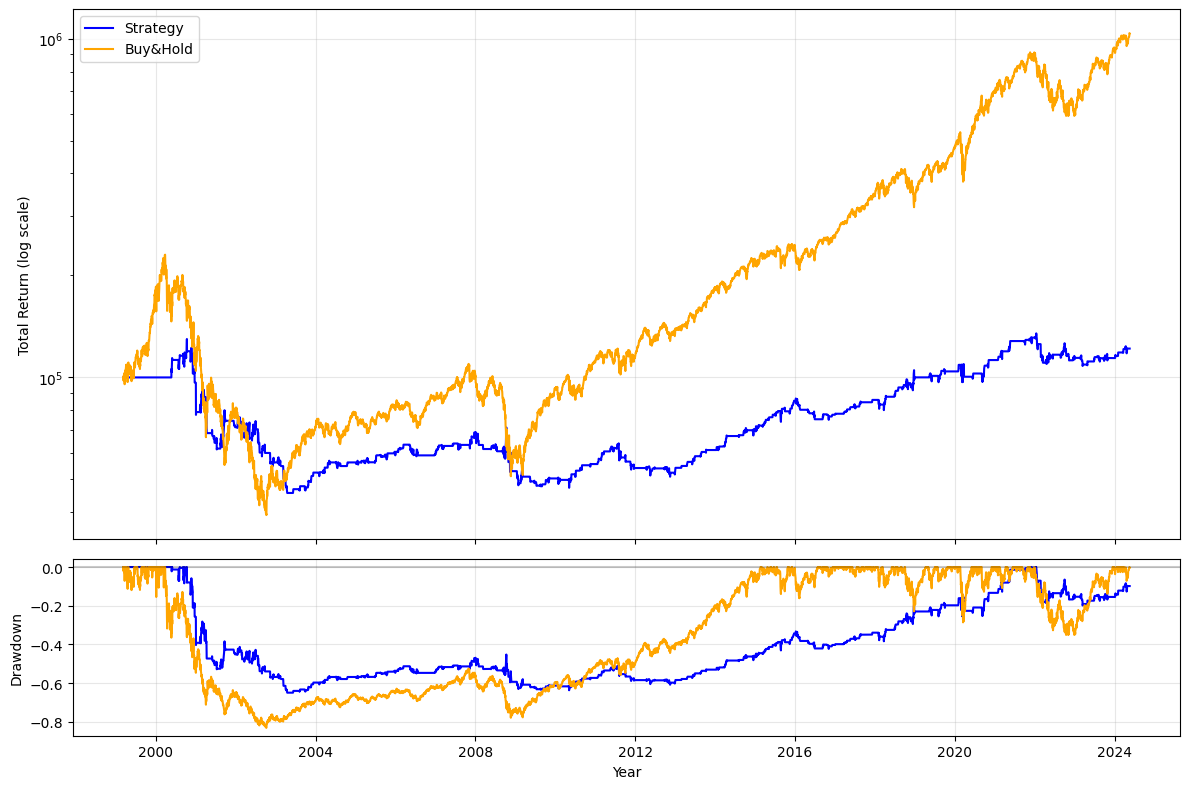

In [98]:
# Define a simple buy and hold strategy for benchmark comparison
class BuyAndHold(Strategy):
    def init(self):
        pass
    
    def next(self):
        if len(self.trades) == 0:
            self.buy()

 # Initialize and run buy & hold benchmark
bt_buyhold = Backtest(data, BuyAndHold, cash=100000, commission=.000)
buyhold_result = bt_buyhold.run()

# Create and display the chart
fig = create_performance_chart(stats, buyhold_result)  # benchmark_result is optional
plt.show()